In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
my_path = '/content/notebooks'
# 구글드라이브 deep-learning-from-scratch-3-master 폴더에 있는 패키지를 colab에 심볼링크걸린 notebooks 폴더 생성 
os.symlink('/content/drive/MyDrive/Colab Notebooks/deep-learning-from-scratch-3-master', my_path)
# 파이썬 모듈 검색 경로추가
sys.path.insert(0, my_path)

# step 53 모델 저장 및 읽어오기

## 53.1 넘파이의 save 함수와 load 함수

### 448

In [ ]:
import numpy as np

x = np.array([1, 2, 3])
np.save('test.npy', x)

x = np.load('test.npy')
print(x)

[1 2 3]


In [ ]:
x1 = np.array([1, 2, 3])
x2 = np.array([4, 5, 6])

np.savez('test.npz', x1=x1, x2=x2)

arrays = np.load('test.npz')
x1 = arrays['x1']
x2 = arrays['x2']
print(x1)
print(x2)

[1 2 3]
[4 5 6]


### 449

In [ ]:
x1 = np.array([1, 2, 3])
x2 = np.array([4, 5, 6])
data = {'x1':x1, 'x2':x2}

np.savez('test.npz', **data)  ## 추가

arrays = np.load('test.npz')
x1 = arrays['x1']
x2 = arrays['x2']
print(x1)
print(x2)

[1 2 3]
[4 5 6]


## 53.2 Layere 클래스의 매개변수를 평평하게

### 450

In [ ]:
from dezero import Layer, Parameter  ## 실행용

layer = Layer()

l1 = Layer()
l1.p1 = Parameter(np.array(1))

layer.l1 = l1
layer.p2 = Parameter(np.array(2))
layer.p3 = Parameter(np.array(3))

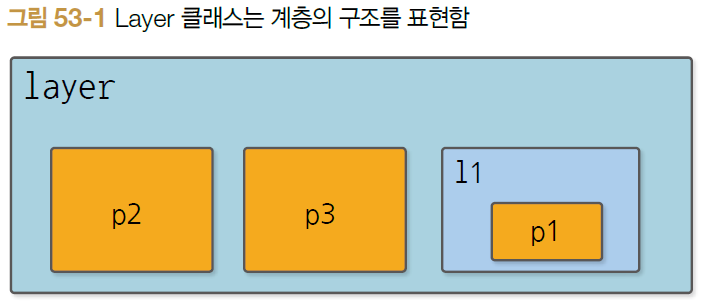

In [ ]:
params_dict = {}
layer._flatten_params(params_dict)
print(params_dict)

{'p2': variable(2), 'p3': variable(3), 'l1/p1': variable(1)}


### 451 layers.py

In [ ]:
# dezero/layers.py

class Layer:
  ### ...

  def _flatten_params(self, params_dict, parent_key=''):
    for name in self._params:
      obj = self.__dict__[name]
      key = parent_key + '/' + name if parent_key else name

      if isinstance(obj, Layer):
        obj._flatten_params(params_dict, key)
      else:
        params_dict[key] = obj


## 53.3 Layer 클래스의 save 함수와 load 함수

### 451~452 layers.py

In [ ]:
# dezero/layers.py

import os

class Layer:
  ### ...
  def save_weights(self, path):
    self.to_cpu()

    params_dict = {}
    self._flatten_params(params_dict)
    arrays_dict = {key: param.data for key, param in params_dict.items() if param is not None}
    try:
      np.savez_compressed(path, **array_dict)
    except (Exception, KeyboardInterrupt) as e:
      if os.path.exists(path):
        os.remove(path)
      raise
  
  def load_weights(self, path):
    npz = np.load(path)
    params_dict = {}
    self._flatten_params(params_dict)
    for key, param in params_dict.items():
      param.data = npz[key]


### 452~453 step53.py

In [ ]:
# steps/step53.py

import os
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

max_epoch = 3
batch_size = 100

train_set = dezero.datasets.MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

# 매개 변수 읽기
if os.path.exists('my_mlp.npz'):  ## 추가
  model.load_weights('my_mlp.npz')  ## 추가

for epoch in range(max_epoch):
  sum_loss = 0

  for x, t in train_loader:
    y = model(x)
    loss = F.softmax_cross_entropy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    sum_loss += float(loss.data) * len(t)

  print('epoch: {}, loss: {:.4f}'.format(epoch + 1, sum_loss / len(train_set)))

# 매개변수 저장하기
model.save_weights('my_mlp.npz') ## 추가


Downloading: train-images-idx3-ubyte.gz?raw=true
[##############################] 100.00% Done
Downloading: train-labels-idx1-ubyte.gz?raw=true
[##############################] 100.00% Done
epoch: 1, loss: 1.9236
epoch: 2, loss: 1.2880
epoch: 3, loss: 0.9242


### save한 피일 load 해서 학습하는지 확인

In [ ]:
# 매개 변수 읽기
if os.path.exists('my_mlp.npz'):  ## 추가
  model.load_weights('my_mlp.npz')  ## 추가

for epoch in range(max_epoch):
  sum_loss = 0

  for x, t in train_loader:
    y = model(x)
    loss = F.softmax_cross_entropy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    sum_loss += float(loss.data) * len(t)

  print('epoch: {}, loss: {:.4f}'.format(epoch + 1, sum_loss / len(train_set)))

# 매개변수 저장하기
model.save_weights('my_mlp.npz') ## 추가

epoch: 1, loss: 0.7385
epoch: 2, loss: 0.6340
epoch: 3, loss: 0.5677
